In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("names.txt", "r") as f:
    words = f.read().splitlines()
print(f"Number of names: {len(words)}")
print(f"Max name length: {max(len(word) for word in words)}")
print(f"First 8 names: {words[:8]}")

Number of names: 32033
Max name length: 15
First 8 names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
chars = sorted(set("".join(words)))
stoi = {char:i+1 for i, char in enumerate(chars)}
stoi["."] = 0
itos = {i:char for i, char in stoi.items()}
vocab_size = len(itos)
print("Vocab size:", vocab_size)
print(itos)

Vocab size: 27
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [4]:
block_size = 3

def build_dataset(words):
    x, y = [], []
    for word in words:
        context = [0] * block_size
        for char, next in zip(word, word[1:]):
            x.append(context)
            y.append([stoi[next]])
            context = context[1:] + [stoi[char]]
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y

import random
random.shuffle(words)
split1 = int(0.8*len(words))
split2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:split1])
Xdev, Ydev = build_dataset(words[split1:split2])
Xte, Yte = build_dataset(words[split2:])

torch.Size([131200, 3]) torch.Size([131200, 1])
torch.Size([16440, 3]) torch.Size([16440, 1])
torch.Size([16440, 3]) torch.Size([16440, 1])


In [5]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

In [6]:
n_embd = 10
n_hidden = 64

C = torch.randn((vocab_size, n_embd))
w1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn((n_hidden)) * 0.1
w2 = torch.randn((n_hidden, vocab_size)) *0.1#/ (n_embd * block_size)**0.5
b2 = torch.randn((vocab_size)) * 0.1

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, w1, b1, w2, b2, bngain, bnbias]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size

idx = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[idx], Ytr[idx]

In [8]:
# embedding
emb = C[Xb]
embcat = emb.view(batch_size, -1)
# layer 1
hprebn = embcat @ w1 + b1
# batchnorm
bnmeani = hprebn.sum(0, keepdim=True) * (1/n) # = sum/n = mean
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = bndiff2.sum(0, keepdim=True) * (1/(n-1))
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv # (x-mean) / std
hpreact = bngain * bnraw + bnbias
# output
h = torch.tanh(hpreact)
logits = h @ w2 + b2

# loss (cross-entropy)
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# pytorch backward
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
           norm_logits, logit_maxes, logits, h, hpreact,
             bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn,
               bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss


tensor(3.4099, grad_fn=<NegBackward0>)

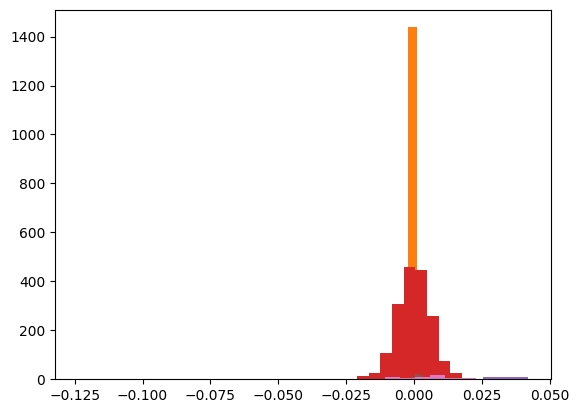

In [9]:
for p in parameters:
    plt.hist(p.grad.detach().view(-1).tolist())
plt.show()

In [ ]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs) 
for b in range(n):
    for y in Yb:
        dlogprobs[b, y] += -1/logprobs[range(n), Yb].numel()

dprobs = dlogprobs * (1/probs) # chain rule
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True) # I guess we have to apply all shape-changing operations to derivative
dcounts_sum = dcounts_sum_inv * -counts_sum**-2
# dloss/dcounts = dloss/dcounts_sum * dcounts_sum/dcounts
# dcounts_sum/d_counts should be 1s in the shape of counts
# assuming counts is [[a, b], [c, d]],
# counts_sum = 
# [[a, b],
# [c, d]].sum(1, keepdim=True)
# --> 
# [[a+c],
# [b+d]]
# Therefore dcounts_sum/da = 1 + 0 = 1
# dcounts_sum/db = 0 + 1 = 1
# etc ->
# counts_grad = 
# [[1, 1],
# [1, 1]]
# So, by chain rule, dloss/dcounts = dloss/dcounts_sum * dcounts_sum/dcounts
# = dloss/dcounts_sum * counts_grad (ones in shape of counts)
# counts are also used in calculation of probs
# so just add dcounts/dloss using chain rule with probs
dcounts = dcounts_sum * torch.ones_like(counts) + counts_sum_inv * dprobs
dnorm_logits = counts * dcounts
# ok so max is a little weird
# imagine you have a tensor a = [[0.2, 6.9], [-1.4, 3.2]]
# and then you take the max of it and transform that to get an output
# if you shift a by a tiny amount to get the gradient of the max of a,
# the max of a will not change, therefore the gradient of the max is zero
dlogit_maxes = -1 * torch.zeros_like(logit_maxes)
dlogits = 0 + dnorm_logits * 1 # dloss/dlogit_maxes * dlogit_maxes/dlogits + dloss/dnorm_logits * dnorm_logits/dlogits
dh = dlogits @ w2.T # dloss/dlogits * dlogits/dh = dlogits * w2 (derivative of matmul is to matmul by transpose??)
dw2 = h.T @ dlogits # ok so its matmul by transpose but make sure its on the same side as before
# also it no longer says its an approximate here but the max diff is 6e-8 which seems like floating point error to me
db2 = torch.ones_like(b2) * dlogits.sum(0, keepdim=True) # dlogits/db2 is just going to be 1s in the shape of b2
# but we also need to apply chain rule by multiplying by dloss/dlogits
# the problem is that dlogits is (32, 27), while db2 is (27)
# we can force dlogits to be (1, 27) by summing along dim 0
# tbh idk why this works \_("/)_/
dhpreact = (1/(torch.pow((torch.exp(hpreact) + torch.exp(-hpreact))/2, 2))) * dh # thanks calculus 1
dbngain = (bnraw * dhpreact).sum(0, keepdim=True) # sum is a lifesaver and idek why it works
dbnbias = 1 * dhpreact.sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True) 
dbnvar = -0.5*(bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff2 = 1/(n-1) * dbnvar
dbndiff = 2 * bndiff * dbndiff2 + bnvar_inv.expand(bndiff.size()) * dbnraw
dbnmeani = -1 * dbndiff.sum(0, keepdim=True)
dhprebn = 1/n * dbnmeani + 1 * dbndiff
dw1 = embcat.T @ dhprebn # again it says not approximate but 3e-8 diff is too small
db1 = 1.0 * dhprebn.sum(0, keepdim=True)
dembcat = dhprebn @ w1.T
demb = dembcat.view(emb.size())
dC = torch.zeros_like(C)
for num, b in enumerate(Xb):
     for num2, i in enumerate(b):
         dC[i] += demb[num][num2]
# -------------------------------------------------------------------------------------------
cmp("logprobs", dlogprobs, logprobs)
cmp("probs", dprobs, probs)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("counts_sum", dcounts_sum, counts_sum)
cmp("counts", dcounts, counts)
cmp("norm_logits", dnorm_logits, norm_logits)
cmp("logit_maxes", dlogit_maxes, logit_maxes)
cmp("logits", dlogits, logits)
cmp("h", dh, h)
cmp("w2", dw2, w2)
cmp("b2", db2, b2)
cmp("hpreact", dhpreact, hpreact)
cmp("bnraw", dbnraw, bnraw)
cmp("bnvar_inv", dbnvar_inv, bnvar_inv)
cmp("bnvar", dbnvar, bnvar)
cmp("bngain", dbngain, bngain)
cmp("bnbias", dbnbias, bnbias)
cmp("bndiff2", dbndiff2, bndiff2)
cmp("bndiff", dbndiff, bndiff)
cmp("bnmeani", dbnmeani, bnmeani)
cmp("hprebn", dhprebn, hprebn)
cmp("w1", dw1, w1)
cmp("b1", db1, b1)
cmp("embcat", dembcat, embcat)
cmp("emb", demb, emb)
cmp("C", dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: False | approximate: True  | maxdiff: 2.9802322387695312e-08
counts_sum_inv  | exact: False | approximate: True  | maxdiff: 2.9802322387695312e-08
counts_sum      | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-10
counts          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
norm_logits     | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
logit_maxes     | exact: False | approximate: True  | maxdiff: 5.122274160385132e-09
logits          | exact: False | approximate: True  | maxdiff: 4.889443516731262e-09
h               | exact: False | approximate: True  | maxdiff: 1.2223608791828156e-09
w2              | exact: False | approximate: True  | maxdiff: 2.0489096641540527e-08
b2              | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
hpreact         | exact: False | approximate: True  | maxdiff: 1.280568540096

In [15]:
A = torch.tensor([[1., 2.], [3., 4.]], requires_grad=True).max(1, keepdim=True).values
B = torch.tensor([[1., 2.], [3., 4.]], requires_grad=True)
f = (B-A).sum()
print(f)
expected = 1
print(expected)
f.backward()
print(A.grad)

tensor(-2., grad_fn=<SumBackward0>)
1
None


C:\Users\brodi\AppData\Local\Temp\ipykernel_12784\1971916642.py:8: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  print(A.grad)


In [16]:
Y = torch.zeros((3, 4))
X = torch.randn((3, 2))
A = torch.randn((2, 4))
for i in range(X.size(0)):
    for j in range(A.size(1)):
        Y[i, j] = sum(X[i, k] * A[k, j] for k in range(A.size(0)))
print(Y)
print(X @ A)

tensor([[-1.0412,  0.7524,  0.0895,  0.1979],
        [-0.4305,  0.4313,  0.4427,  0.0980],
        [-0.1568,  0.1848,  0.2551,  0.0394]])
tensor([[-1.0412,  0.7524,  0.0895,  0.1979],
        [-0.4305,  0.4313,  0.4427,  0.0980],
        [-0.1568,  0.1848,  0.2551,  0.0394]])
